In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import nltk

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from langdetect import detect

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## **1. Entendimiento de los datos**
***
En esta sección se realizan todas las operciones asociadas a la exploración, análisis, entendimiento y limpieza de los datos. Este análisis se utilizará posteriormente para soportar el proceso de toma de desiciones.

### **1.1 Carga de los datos**

Se inicia cargando los datos presentes en el archivo *ODScat_345.xlsx* en un DataFrame y se reportan tanto el número de características como el número de registros cargados.

In [3]:
datos_ODS = pd.read_excel('./data/ODScat_345.xlsx')
print('# Filas: ', datos_ODS.shape[0])
print('# Columnas: ', datos_ODS.shape[1])

# Filas:  4049
# Columnas:  2


Posteriormente, se obtiene una muestra de 20 registros aleatorios con el fin de crear u obtener una idea acerca de la naturaleza y contenido de los datos cargados.

In [4]:
datos_ODS.sample(20)

,Textos_espanol,sdg
2660,Si bien la mejora de la seguridad y la presenc...,5
2225,"A nivel estatal, las mujeres ocupaban una medi...",5
3411,"Entre las mujeres transexuales, el consumo de ...",3
2697,"En todas las regiones, las mujeres dedican al ...",5
174,"En 2012, el 48,4% de las muertes fueron de muj...",3
943,"Como se discutió en el Capítulo 2, hay margen ...",3
572,Se espera que la nueva lista de precios de pro...,3
2235,Una herramienta de este tipo podría ayudar a l...,5
2072,Muchas jóvenes se pierden en la transición de ...,5
2148,La estrecha interacción con modelos femeninos ...,5


### **1.2. Análisis de los datos**

Inicialmente, se verifica el tipo de dato correspondiente a las características o columnas cargadas. Debido al contexto del problema, se espera que ambas columnas sean de tipo String.

In [5]:
datos_ODS.dtypes

Textos_espanol    object
sdg                int64
dtype: object

Se puede observar que la columna *sdg* es de tipo entero, por lo cual, se decide convertir a string para evitar posibles problemas en la construcción y entrenamiento de los modelos. Posteriormente, se verifica el porcentaje de valores faltantes asociados a las carcaterísticas cargadas.

In [6]:
(datos_ODS.isnull().sum() / datos_ODS.shape[0]).sort_values(ascending = False)

Textos_espanol    0.0
sdg               0.0
dtype: float64

Dado que no se presentan valores faltantes, no es necesario imputar ni eliminar registros. Se procede a realizar un pie chart para visualizar los valores asociados a la variable *sdg* y su distribución porcentual.

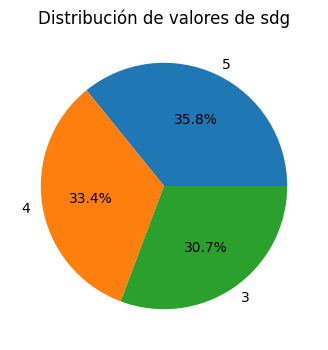

In [7]:
datos_ODS['sdg'].value_counts().plot(kind='pie', figsize=(4, 4), autopct='%1.1f%%')
plt.title('Distribución de valores de sdg')
plt.ylabel('')
plt.show()

A partir del gráfico, se verifica que los valores presentes en la columna *sdg* son consistentes con la información presentada por el negocio y que la cantidad de registros asociados a cada categoría se encuentra relativamente equilibrada. Se procede a verificar el idioma en el cual estan escritos los textos.

In [8]:
datos_ODS['idioma']= datos_ODS['Textos_espanol'].apply(detect)
datos_ODS['idioma'].value_counts(normalize=True)

idioma
es    0.996542
en    0.001976
fr    0.001482
Name: proportion, dtype: float64

A partir del análisis, se detecta que existen textos en Español, Inglés y Fránces, siendo la categoría más significativa el idioma Español con más de un 99% de registros. Debido a que el negocio informó que los textos a procesar estan únicamente en Español, se decíde eliminar todos aquellos regsitros asociados a los otros idiomas. Posteriormente, se continúa el análisis revisando la distribución de los textos en función de su longitud.

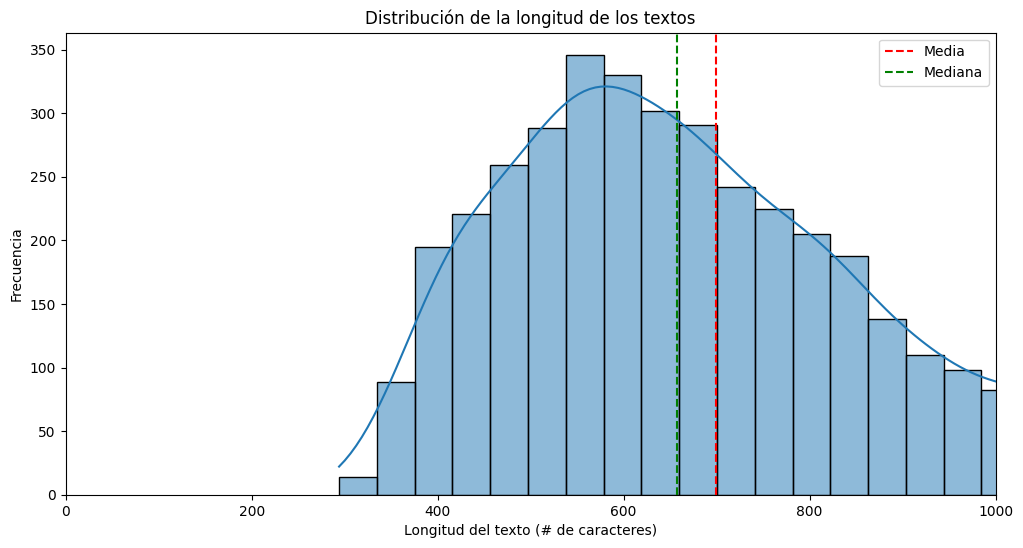

In [9]:
datos_ODS['longitud'] = datos_ODS['Textos_espanol'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(datos_ODS['longitud'], bins=30, kde=True)
plt.xlim(0, 1000)

plt.xlabel('Longitud del texto (# de caracteres)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la longitud de los textos')

plt.axvline(x=datos_ODS['longitud'].mean(), color='red', linestyle='--', label='Media')
plt.axvline(x=datos_ODS['longitud'].median(), color='green', linestyle='--', label='Mediana')
plt.legend()

plt.show()

A partir de la gráfica, se puede determinar que los textos presentes en la columna  *Texto_espanol* tienen una longitud media de alrededor de 700 carácteres, que los textos más cortos son de aproximadamente 300 caracteres y que los más largos alcanzan los 1000 caracteres. Para continuar con el análisis, se presenta la frecuencia de las 15 palabras más comunes, sin tener en cuenta stopwords ni caracteres de control.

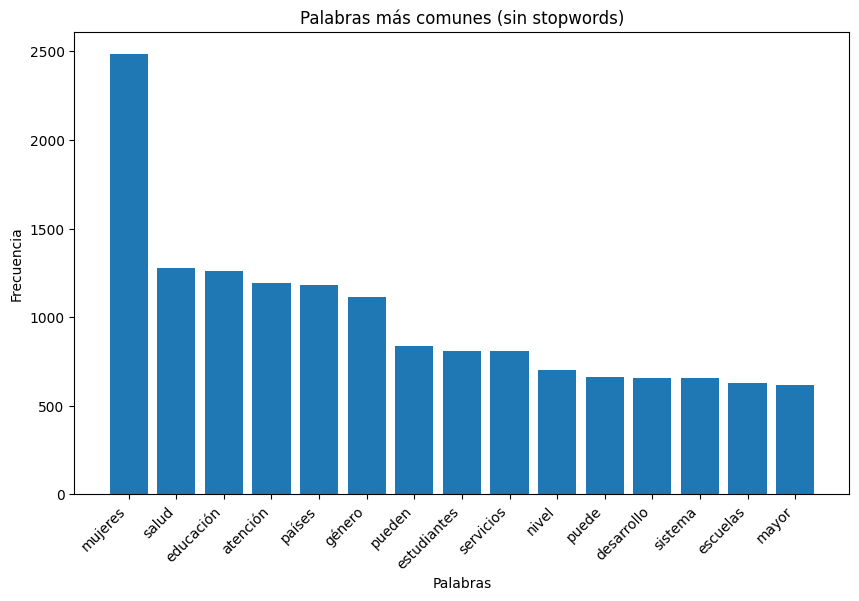

In [10]:
stop_words = set(stopwords.words('spanish'))

texto_concatenado = ' '.join(datos_ODS['Textos_espanol'])
palabras = texto_concatenado.split()

palabras_filtradas = [palabra.lower() for palabra in palabras if palabra.lower() not in stop_words]
frecuencias = Counter(palabras_filtradas)

numero_palabras = 15
palabras_comunes = [(palabra, frecuencia) for palabra, frecuencia in frecuencias.items() if palabra.isalpha()]
palabras_comunes = sorted(palabras_comunes, key=lambda x: x[1], reverse=True)[:numero_palabras]
palabras, frecuencias = zip(*palabras_comunes)

plt.figure(figsize=(10, 6))
plt.bar(palabras, frecuencias)
plt.title('Palabras más comunes (sin stopwords)')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, ha='right')
plt.show()

Del mismo modo, se grafican las frecuencias de los bigramas, osea la unión de dos palabras, más comúnes en los datos.

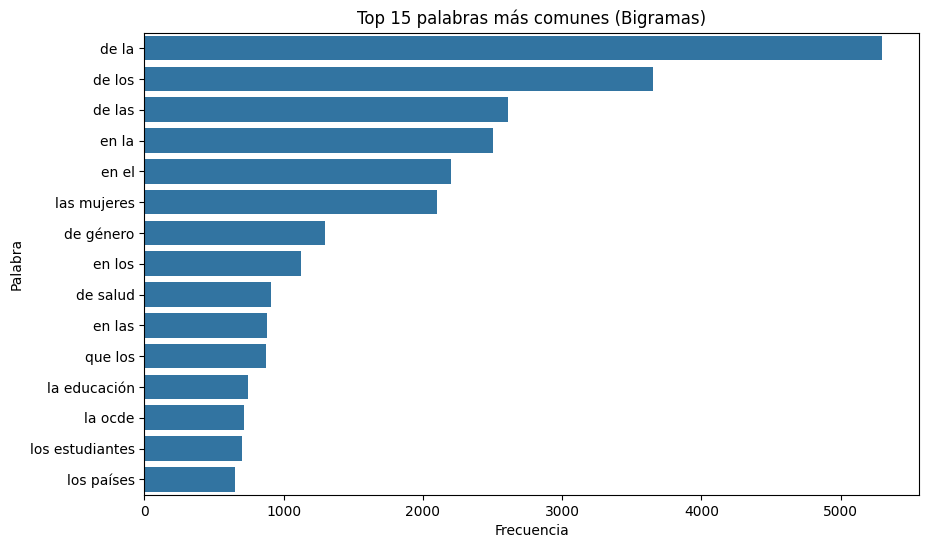

In [11]:
def obtener_palabras_top_n(corpus, n, size):
    vector = CountVectorizer(ngram_range=(size, size)).fit(corpus)
    bolsa_de_palabras = vector.transform(corpus)
    suma_palabras = bolsa_de_palabras.sum(axis=0)
    frecuencias = [(palabra, suma_palabras[0, idx]) for palabra, idx in vector.vocabulary_.items()]
    frecuencias = sorted(frecuencias, key=lambda x: x[1], reverse=True)
    return frecuencias[:n]

palabras_comunes = obtener_palabras_top_n(datos_ODS['Textos_espanol'], 15, 2)

palabras = [palabra[0] for palabra in palabras_comunes]
frecuencias = [frecuencia[1] for frecuencia in palabras_comunes]

plt.figure(figsize=(10, 6))
sns.barplot(x=frecuencias, y=palabras)
plt.title('Top 15 palabras más comunes (Bigramas)')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()


A partir de los bigramas, se identifica que las uniones de palabras más comunes corresponden a stopwords. De la misma forma, se repite el procedimiento con los trigramas más comunes.

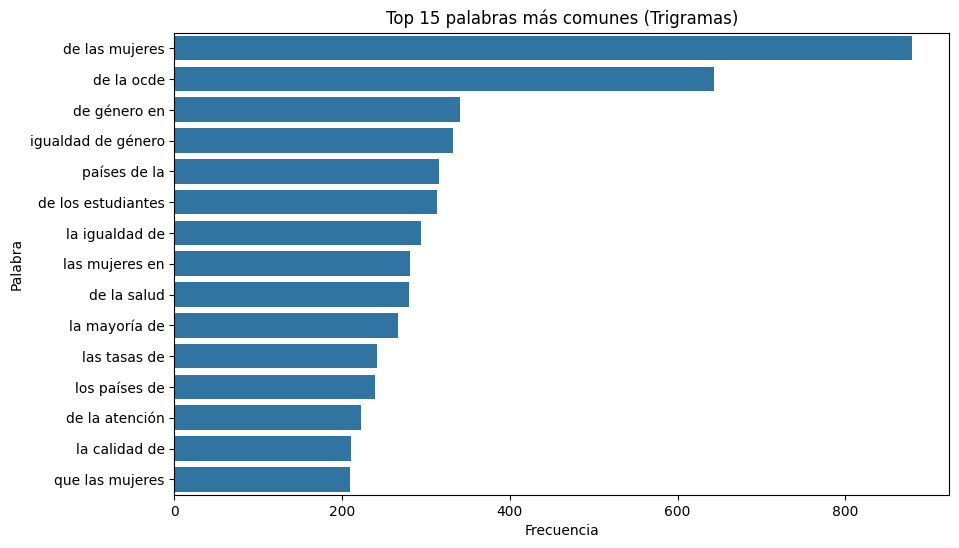

In [12]:
palabras_comunes = obtener_palabras_top_n(datos_ODS['Textos_espanol'], 15, 3)

palabras = [palabra[0] for palabra in palabras_comunes]
frecuencias = [frecuencia[1] for frecuencia in palabras_comunes]

plt.figure(figsize=(10, 6))
sns.barplot(x=frecuencias, y=palabras)
plt.title('Top 15 palabras más comunes (Trigramas)')
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.show()

Nuevamente se evidencia que las combinaciones más comunes contienen, en su mayoría, stopwords. Finalmente, se gráfican las 15 palabras más largas en los textos.

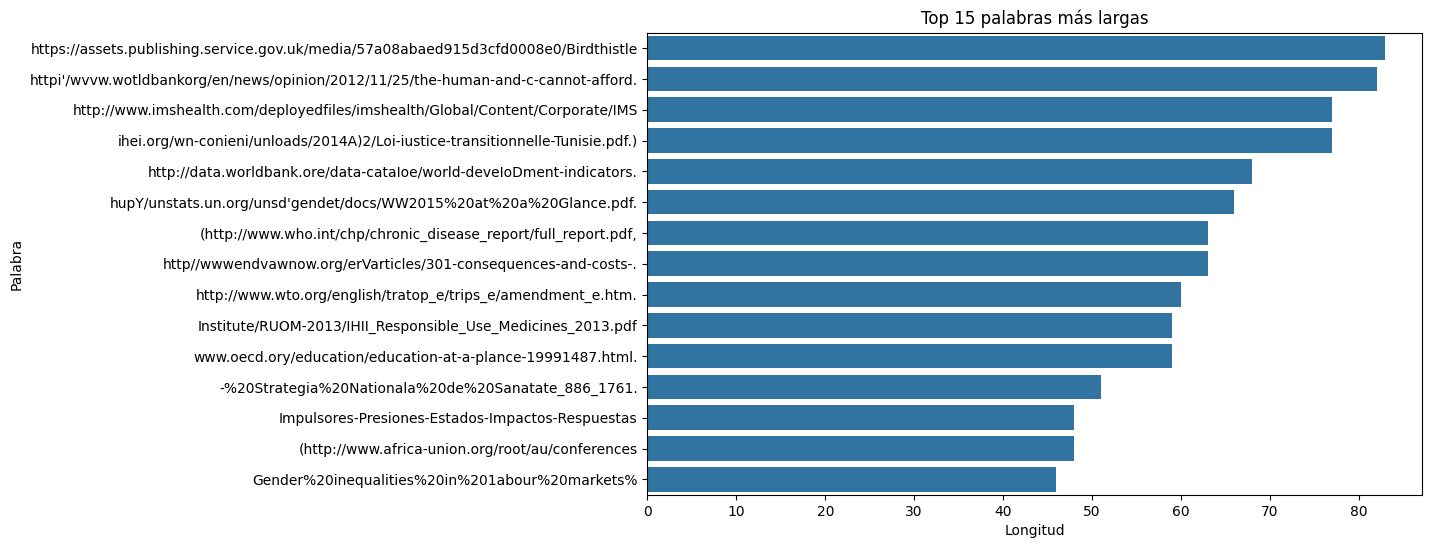

In [13]:
def obtener_top_palabras_largas(corpus, n):
    palabras = ' '.join(corpus).split()
    longitudes = [(palabra, len(palabra)) for palabra in palabras]
    longitudes = sorted(longitudes, key=lambda x: x[1], reverse=True)
    return longitudes[:n]

palabras_largas = obtener_top_palabras_largas(datos_ODS['Textos_espanol'], 15)
palabras = [palabra[0] for palabra in palabras_largas]
longitudes = [longitud[1] for longitud in palabras_largas]

plt.figure(figsize=(10, 6))
sns.barplot(x=longitudes, y=palabras)
plt.title('Top 15 palabras más largas')
plt.xlabel('Longitud')
plt.ylabel('Palabra')
plt.show()


A partir de esta gráfica, se puede evidenciar que las palabras más largas corresponden a enlaces a sitios web o fragmentos de rutas. Se toma la desición de eliminar estas palabras con el fin de reducir la cardinalidad del modelo y obtener mejores resultados. Como cierre de este proceso se elimina el DataFrame utilizado en el análisis de datos.

In [14]:
del datos_ODS

### **1.3 Desiciones tomadas**

Luego de analizar profundamente los datos y de utilizar los conocimientos del curso para la construcción de modelos de clasificación, se propone el siguiente flujo de desiciones para la limpieza de los datos.

1. **Conversión de datos:** Se decide convertir ambas características o columnas al tipo de dato String con el fin de evitar problemas en el entrenaimeitno de los modelos de clasificación. Aunque la columa *Textos_espanol* ya se encuentra en el tipo de dato correcto, se vuelve a aplicar la transformación para asegurar resultados confiables.

2. **Eliminación de idiomas inconsistentes:** Se decíde eliminar todas aquellas filas o registros que se encuentran en Inglés o Fránces. Esta desición se tomo con el fin de reducir la cardinalidad del modelo y mantener la consistencia con las reglas del negocio.

3. **Correción de codificación:** Debido a que al analizar los datos se observaron caracteres mal codificados, sobre todo la letra ñ y vocales con tíldes, se decide reemplazar estos caracteres por su codificación correcta para obtener una mejor comprensión del contexto y evitar errores en el proceso de entrenamiento de los modelos.

4. **Conversión a letras mínusculas:** Con el fin de evitar que palabras como Hola y hola se codifiquen con representaciones distintas y, por ende, se aumente la cardinalidad del modelo, se decide convertir todos los textos a su representación en letras minusculas. 

5. **Eliminar caracteres:** Se decide eliminar todos los caracteres de control y signos de puntuación debido a que no aportan valor al modelo y pueden llegar a complicar el proceso de conversión de los datos a vectores númericos.

6. **Eliminación de stopwords:** Como se evidencio en el análisis de los datos, hay una gran presencia de stopwords que no aportan valor y solo cumplen funciones de enlace de palabras. Se deciden eliminar todas estas palabras y, a su vez, se toma la desición de eliminar todas aquellas palabras con longitud menor o igual a dos.

7. **Eliminar palabras no alafbéticas:** Se decide eliminar todas aquellas palabras que no estan compuestan en su totalidad por caracteres alfabéticos. De esta forma, se garantiza la eliminación de palabras inconsistentes y se reduce la cardinalidad del modelo.

8. **Reemplazar acentos:** Dado que la cantidad de palabras codificadas se ve afectada al tener en cuenta los acentos, se decide reemplazar todas las ocurrencias de vocales con tílde. De esta manera se reduce la cardinalidad del modelo y se unifican términos simnilares.

9. **Lematizar verbos:** Se decide lematizar todos aquellos verbos cuya longitud sea mayor o igual a 5. Este proceso se lleva a cabo para reducir la cardinalidad del modelo y para evitar la influencia de los tiempos verbales en la predicción de clases.

10. **Eliminación de rutas y enlaces:** Se decide eliminar todos aquellos fragmentos que puedan ser asociados a páginas web, enlaces o rutas a archivos debido a que no aportan valor al modelo y si pueden aumentar la cardinalidad del mismo.

## **2. Limpieza y preparación de los datos**
***
En esta sección, se definen todas las funciones necesarias para llevar a cabo la limpieza de los datos mencionada anteriormente. Para cada paso del proceso mencionado, se define una función que implementa la desición.

### **2.1 Conversión de datos**

In [3]:
def convertir_tipos(dataFrame):
    dataFrame["sdg"] = dataFrame["sdg"].astype(str)
    dataFrame["Textos_espanol"] = dataFrame["Textos_espanol"].astype(str)
    return dataFrame

### **2.2 Eliminación de idiomas inconsistentes**

In [4]:
def eliminar_otros_idiomas(dataFrame):
    dataFrame['idioma']= dataFrame['Textos_espanol'].apply(detect)
    dataFrame = dataFrame[dataFrame['idioma'] == 'es']
    dataFrame = dataFrame.drop(['idioma'], axis=1)
    return dataFrame

### **2.3 Corrección de codificación**

In [5]:
def convertir_UTF8(dataFrame):

    utf8_a_ansi = {
		"Ã": "Á",
		"Ã¡": "á",
		"Ã‰": "É",
		"Ã©": "é",
		"Ã": "Í",
		"Ã­": "í",
		"Ã“": "Ó",
		"Ã³": "ó",
		"Ãš": "Ú",
		"Ãº": "ú",
		"Ã‘": "Ñ",
		"Ã±": "ñ",
		"Â¿": "¿"
    }

    def reemplazar_texto(texto, reemplazos):
        for utf8, ansi in reemplazos.items():
            texto = texto.replace(utf8, ansi)
        return texto
    
    dataFrame['Textos_espanol'] = dataFrame['Textos_espanol'].apply(lambda x: reemplazar_texto(x, utf8_a_ansi))

    return dataFrame

### **2.4 Conversión a letras minusculas**

In [6]:
def convertir_minuscula(dataFrame):
    dataFrame['Textos_espanol'] = dataFrame['Textos_espanol'].str.lower()
    return dataFrame

### **2.5 Eliminación de caracteres**

In [7]:
def reemplazar_caracteres(dataFrame):

    tabla_traduccion = str.maketrans(' ', ' ', string.punctuation)

    def reemplazar_texto(texto, reemplazos):
        return texto.translate(reemplazos)
    
    dataFrame['Textos_espanol'] = dataFrame['Textos_espanol'].apply(lambda x: reemplazar_texto(x, tabla_traduccion))
    
    return dataFrame

### **2.6 Eliminación de stopwords**

In [8]:
def eliminar_stopwords(dataFrame):
    
    paradas = set(stopwords.words('spanish'))
    
    def reemplazar_texto(texto, reemplazos):
        return ([palabra.strip() for palabra in texto.split(' ') if palabra not in reemplazos and len(palabra) > 2])
    
    dataFrame['Textos_espanol'] = dataFrame['Textos_espanol'].apply(lambda x: reemplazar_texto(x, paradas))
    
    return dataFrame

### **2.7 Eliminación de plabras no alfabéticas**

In [9]:
def filtrar_alfabeticas(dataFrame):

    def filtar_palabras(palabras):
        return [palabra for palabra in palabras if palabra.isalpha()]
    
    dataFrame['Textos_espanol'] = dataFrame['Textos_espanol'].apply(lambda x: filtar_palabras(x))

    return dataFrame

### **2.8 Reemplazar acentos**

In [10]:
def reemplazar_tildes(dataFrame):

    def reemplazar_acentos(texto):
        texto = texto.replace("á", "a")
        texto = texto.replace("é", "e")
        texto = texto.replace("í", "i")
        texto = texto.replace("ó", "o")
        texto = texto.replace("ú", "u")
        return texto

    def reemplazar_acentos_lista(palabras):
        return [reemplazar_acentos(palabra) for palabra in palabras]

    dataFrame['Textos_espanol'] = dataFrame['Textos_espanol'].apply(lambda x: reemplazar_acentos_lista(x))

    return dataFrame

### **2.9 Lematización de verbos**

In [11]:
def lematizar_verbos(dataFrame):
    lematizador = WordNetLemmatizer()

    def lematizar(palabras):
        lemas = []
        for palabra in palabras:
            if len(palabra) > 4:
                lemas.append(lematizador.lemmatize(palabra, pos='v'))
            else:
                lemas.append(palabra)
        return lemas

    
    dataFrame['Textos_espanol'] = dataFrame['Textos_espanol'].apply(lambda x: lematizar(x))
    return dataFrame

### **2.10 Eliminación de rutas y enlaces**

In [12]:
def eliminar_enlaces(dataFrame):

    def eliminador(palabras):
        return [palabra for palabra in palabras if (('http' not in palabra) and ('https' not in palabra) and  ('www' not in palabra))]
    
    dataFrame['Textos_espanol'] = dataFrame['Textos_espanol'].apply(lambda x: eliminador(x))
    
    return dataFrame

### **2.11 Función de preprocesamiento**

Una vez definidas todas las transformaciones, se crea una función que las encapsula en su totalidad y que las aplica a un dataframe dado.

In [13]:
def preprocesamiento(dataFrame, eliminacion):
    
    dataFrame = convertir_tipos(dataFrame)
    if eliminacion:
        dataFrame = eliminar_otros_idiomas(dataFrame)
    dataFrame = convertir_UTF8(dataFrame)
    dataFrame = convertir_minuscula(dataFrame)
    dataFrame = reemplazar_caracteres(dataFrame)
    dataFrame = eliminar_stopwords(dataFrame)
    dataFrame = filtrar_alfabeticas(dataFrame)
    dataFrame = reemplazar_tildes(dataFrame)
    dataFrame = lematizar_verbos(dataFrame)
    dataFrame = eliminar_enlaces(dataFrame)
    dataFrame['Textos_espanol'] = dataFrame['Textos_espanol'].apply(lambda x: ' '.join(map(str, x)))

    return dataFrame

### **2.12 Limpieza de los datos**

Finalmente, se cargan nuevamente los datos y se les aplican las transformaciones creadas anteriormente. Con el fin de observar si se aplicaron correctamente se escoge una muestra de 20 datos aleatorios y se visualiza.

In [14]:
datos_limpios = pd.read_excel('./data/ODScat_345.xlsx')
datos_limpios = preprocesamiento(datos_limpios, True)
datos_limpios.sample(20)

,Textos_espanol,sdg
3144,proceso preparacion reforma folkeskole part in...,4
787,alcohol cuatro factor relacionados estilo vida...,3
1611,reduccion curriculo lleva dedique tiempo areas...,4
2607,luz aplicacion enfoque politicas publicas toma...,5
3582,federacion rusa siguio apoyando provision capa...,3
1785,utilizaron escalas desarrollo seguir cambios s...,4
1963,proceso reciben apoyo escuelas necesidades esp...,4
3728,asi paises contenido educacion inicial puede s...,4
441,tasas mortalidad prematura grupo edad años car...,3
1176,numero profesores universitarios crecio aument...,4


## **3. Vectorización de los datos**
***
Para entrenar los modelos es necesario usar datos numéricos en forma de matriz o vector, por lo cual, se decide utilizar la estrategia Tf-Idf para vectorizar los textos a clasificcar. Se decide utilizzar esta estrategia ya que estandariza la importancia de las palabras en función del corpus y favorece la obtención de mejores resultados. Cabe resaltar que, luego de vectorizar los datos, se dividen en un conjunto de entrenamiento (80%) y uno de prueba (20%). 

In [27]:
vectorizador = TfidfVectorizer()

X = vectorizador.fit_transform(datos_limpios['Textos_espanol'])
Y = datos_limpios['sdg']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X.shape)

(4035, 18399)


## **4. Construcción del modelo 1: Random Forest - Nicolas Rozo Fajardo**

Se construye el primer modelo haciendo uso del algoritmo Random Forest y de la técnica de validación cruzada con K-folds estratificados. 

### **4.1 Instanciación del modelo**

In [28]:
random_forest = RandomForestClassifier(random_state = 42)

### **4.2 Definición validación cruzada**

Se define el diccionario de hiperparámetros sobre los cuales se realizará la cross validation y se generan los k-folds estratificados para el mismo fin.

In [29]:
hiperparametros_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [10, 15, 20]
}

k_folds_rf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
selector_rf = GridSearchCV(estimator = random_forest, param_grid = hiperparametros_rf, cv=k_folds_rf, n_jobs=-1, verbose=2, scoring='f1_weighted')

### **4.3 Entrenamiento y selección del mejor modelo**

Posteriormente, se inicia el proceso de entrenamiento y selección del mejor modelo. Para el caso específico de este modelo, el mejor rendimiento, dado por la métrica weighted F1, se obtiene con los hiperparametros *max_depth:* 30, *min_samples_split:* 15 y *n_estimators:* 300.

In [30]:
selector_rf.fit(X_train, Y_train)

print('Mejores hiperparámetros : ', selector_rf.best_params_)
print('Mejors puntaje F1: ', selector_rf.best_score_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
Mejores hiperparámetros :  {'max_depth': 30, 'min_samples_split': 15, 'n_estimators': 300}
Mejors puntaje F1:  0.976124292960512


Una vez determinado el mejor modelo, se obtiene para su evaluación.

In [31]:
mejor_modelo_rf = selector_rf.best_estimator_

### **4.4 Evaluación del mejor modelo**

Se inicia evaluando el rendimiento del mejor modelo sobre el conjunto de datos de entrenamiento. 

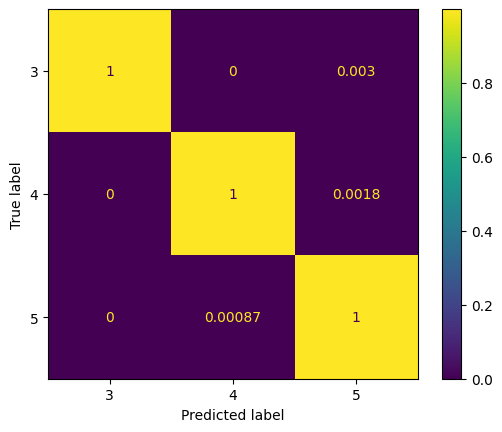

In [32]:
Y_pred_train_rf = mejor_modelo_rf.predict(X_train)

matriz_confusion_train_rf = confusion_matrix(Y_train, Y_pred_train_rf, labels=mejor_modelo_rf.classes_, normalize='true')
matriz_train_rf = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_train_rf, display_labels=mejor_modelo_rf.classes_)  
matriz_train_rf.plot()

In [33]:
print(classification_report(Y_train, Y_pred_train_rf))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00       993
           4       1.00      1.00      1.00      1086
           5       1.00      1.00      1.00      1149

    accuracy                           1.00      3228
   macro avg       1.00      1.00      1.00      3228
weighted avg       1.00      1.00      1.00      3228



A continuación, se presenta un análisis detallado de los resultados:

1. **Matriz de confusión:** A partir de la matriz de confusión se puede evidenciar que el modelo entrenado clasifica correctamente la mayoría de los datos presentes en el conjunto de entrenamiento. Aunque los puntos normalizados indican que un 100% de los datos se clasificaron correctamente, es importante recalcar que existen valores mayores a 0 en algunas otras casillas, lo cual indica que si existen alguno valores que fueron clasificados incorrectamente. 

2. **Sensibilidad:** Los valores de sensibilidad son reportados como 1 debido a que la gran mayoría de textos fueron clasificados en su clase positiva correspondiente.Esto es, el modelo clasifico la gran mayoria de los textos en su clase correspondeinte o esperada.

3. **Precisión:** Los valores de precisión son reportados como 1 debido a que la gran mayoría de textos clasificados en la clase positiva efectivamente pertenencen a la clase predicha. Estoes, el modelo cuenta con la capacidad de inferir correctamente la clase de un texto y por ende, la mayoría de los textos clasificados pertenecen a la clase predicha.

4. **F1-Score:** Los resultados mencionados anteriormente se resumen en un F1-score de 0.97, lo que indica que no todos los datos fueron clasificados correctamente pero sí la gran mayoría. Se esperaría que el modelo se desempeñe correctamente siempre y cuando se pueda demostrar que cuenta con una buena capacidad de generalización.

Como conclusión preliminar, el modelo entrenado haciendo uso del algortimo Random Forest parece estar un poco sobreentrenado, lo cual se evidencia en métricas reportadas con el valor de 1. Aún así, es necesario evaluar el modelo con el conjunto de datos de prueba para validar si el sobreentrenamiento observado esta afectado considerablemente la capacidad de generalización o si, por el contrario, el modelo cuenta con capacidad para generalizar. Cabe resaltar que el modelo presentado es el mejor en un espacio de búsqueda de 270 modelos ajustados, por lo cual se espera que pueda brindar un buen rendimiento.

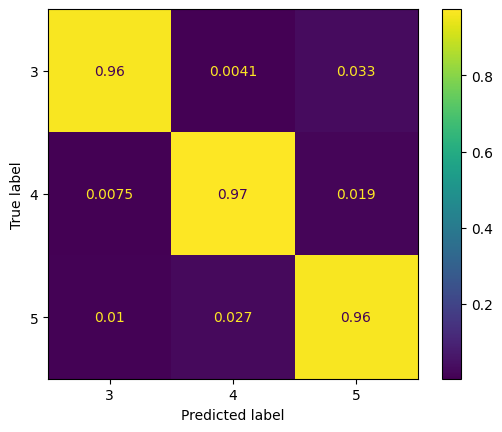

In [34]:
Y_pred_rf = mejor_modelo_rf.predict(X_test)

matriz_confusion_rf = confusion_matrix(Y_test, Y_pred_rf, labels=mejor_modelo_rf.classes_, normalize='true')
matriz_rf = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_rf, display_labels=mejor_modelo_rf.classes_)  
matriz_rf.plot()

In [35]:
print(classification_report(Y_test, Y_pred_rf))

              precision    recall  f1-score   support

           3       0.98      0.96      0.97       245
           4       0.97      0.97      0.97       266
           5       0.96      0.96      0.96       296

    accuracy                           0.97       807
   macro avg       0.97      0.97      0.97       807
weighted avg       0.97      0.97      0.97       807



El análisis detallado de los resultados obtenidos se presenta a continuación:

1. **Matriz de confusión:** En la matriz de confusión se observa que el algoritmo clasifica correctamente los datos de prueba en sus clases esperadas, con porcentajes del 96% para la clase 3, 97% para la clase 4, y 96% para la clase 5. Estos resultados difieren aproximadamente en 4 puntos porcentuales respecto a los obtenidos en el entrenamiento, sin embargo, al ser cercanos se podría afirmar que el modelo cuenta con una capacidad de generalización correcta y no se encuentra sobreentrenado.

2. **Sensibilidad:** Los valores de sensibilidad reportados varian entre 3 y 4 puntos porcentuales respecto a las métricas obtenidas durante el entrenamiento. La interpretación que podemos obtener de los valores es que, por ejemplo, aproximadamente el 98% de los valores clasificados en la clase 3 fueron clasificados correctamente, osea, si pertenecen a la clase dada. Esta interpretación se puede aplicar a las otras métricas de sensibilidad y se puede concluir que la presición entre las clases se encuentra casi equilibrada (la diferencia son 2 puntos porcentules).

3. **Precisión:** Los valores de precisión reportados varian en 4 puntos porcentuales respecto a las métricas obtenidas durante el entrenamiento. La interpretación que podemos obtener de los valores es que, por ejemplo, aproximadamente el 97% de los textos clasificados como categoría 4 efectivamente pertencen a la clase en la cual fueron clasificados y el 3% restantes se clasificaron en la clase 4 pero no pertenecen realmente a ella. Esta interpretación se puede aplicar a las otras métricas de precisión y se puede concluir que, aqunue se comenten ciertos errores, el modelo cuenta con una habilidad notable para clasificar correctamente los textos.

4. **F1-Score:** La totalidad de los resultados mencionados anteriormente se resumen en un weighted F1-score promedio de 97%, lo cual indica que el modelo tiene una gran capacidad para generalizar sus predicciones y que la cantidad de errores que se comete no es considerablemente alta.

En conslusión, se puede afirmar que este modelo presenta un buen rendimiento debdio a que cuenta con capacidad para generalizar sus resultados y, al mismo tiempo, presenta buenas métricas de rendimiento. EL modelo no es perfecto pero garantiza que la mayoría de predicciones realizadas van a ser correctas y, por ende, podrá ser usado de manera confiable por el negocio en sus labores.

## **5. Construcción del modelo 2: KNN - Laura Calderón Molina**


Posteriormente, se construye el segundo modelo haciendo uso del algoritmo KNN y de la técnica de validación cruzada con K-folds estratificados. 

### **5.1 Instanciación del modelo**

In [36]:
modelo_knn = KNeighborsClassifier()

### **5.2 Definición validación cruzada**

Se define el diccionario de hiperparámetros sobre los cuales se realizará la cross validation y se generan los k-folds estratificados para el mismo fin.

In [37]:
hiperparametros_knn = {
   'n_neighbors': [3, 5, 7, 9, 11], 
   'weights': ['uniform', 'distance'], 
   'metric': ['euclidean', 'manhattan']
}

k_folds_knn = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
selector_knn = GridSearchCV(estimator=modelo_knn, param_grid=hiperparametros_knn, cv=k_folds_knn, n_jobs=-1, verbose=2, scoring='f1_weighted')

### **5.3 Entrenamiento y selección del mejor modelo**

Posteriormente, se inicia el proceso de entrenamiento y selección del mejor modelo. Para el caso específico de este modelo, el mejor rendimiento, dado por la métrica weighted F1, se obtiene con los hiperparametros *metric:* euclidean, *n_neighbors:* 11 y *weights:* distance.

In [38]:
selector_knn.fit(X_train, Y_train)
   
print(f"Mejores hiperparámetros k-NN: {selector_knn.best_params_}")
print(f"Mejor puntaje f1 en validación cruzada: {selector_knn.best_score_}")

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Mejores hiperparámetros k-NN: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Mejor puntaje f1 en validación cruzada: 0.9594080189285645


Una vez determinado el mejor modelo, se obtiene para su evaluación.

In [39]:
mejor_modelo_knn = selector_knn.best_estimator_

### **5.4 Evaluación del mejor modelo**

Se inicia evaluando el rendimiento del mejor modelo sobre el conjunto de datos de entrenamiento. 

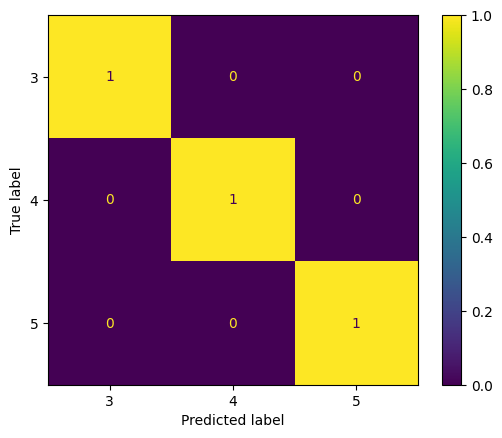

In [40]:
Y_pred_train_knn = mejor_modelo_knn.predict(X_train)

matriz_confusion_train_knn = confusion_matrix(Y_train, Y_pred_train_knn, labels=mejor_modelo_knn.classes_, normalize='true')
matriz_train_knn = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_train_knn, display_labels=mejor_modelo_knn.classes_)  
matriz_train_knn.plot()

In [41]:
print(classification_report(Y_train, Y_pred_train_knn))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00       993
           4       1.00      1.00      1.00      1086
           5       1.00      1.00      1.00      1149

    accuracy                           1.00      3228
   macro avg       1.00      1.00      1.00      3228
weighted avg       1.00      1.00      1.00      3228



A continuación, se presenta un análisis detallado de los resultados:


1. **Matriz de confusión:** La matriz de confusión indica que el modelo clasifica correctamente todas las instancias del conjunto de entrenamiento. No se observa ningún error de clasificación, lo que sugiere que el modelo tiene un ajuste perfecto para este conjunto de datos.

2. **Sensibilidad:** Los valores de sensibilidad son 1 en todas las clases. Esto significa que el modelo clasifica correctamente todas las instancias de cada clase, sin dejar ninguna fuera.

3. **Precisión:** La precisión también es 1 en todas las clases, lo que indica que todas las predicciones hechas por el modelo son correctas. Es decir, cada instancia clasificada como positiva pertenece realmente a esa clase.

4. **F1-Score:** El F1-Score es 1.00, lo que refleja un equilibrio perfecto entre precisión y sensibilidad, indicando que el modelo clasifica correctamente todos los textos en el conjunto de entrenamiento.

El modelo KNN muestra un rendimiento perfecto en el conjunto de entrenamiento, lo que sugiere que está sobreajustado. Si bien clasifica correctamente todos los datos, esto podría ser indicativo de que el modelo ha memorizado el conjunto de entrenamiento, y es necesario evaluar su capacidad de generalización en el conjunto de prueba.


Con el fin de evaluar la capacidad de generalización del modelo sobre instancias de datos nuevas, se repiten nuevamente las métricas sobre los datos predecidos por el modelo a partir del conjunto de datos de entrenamiento.

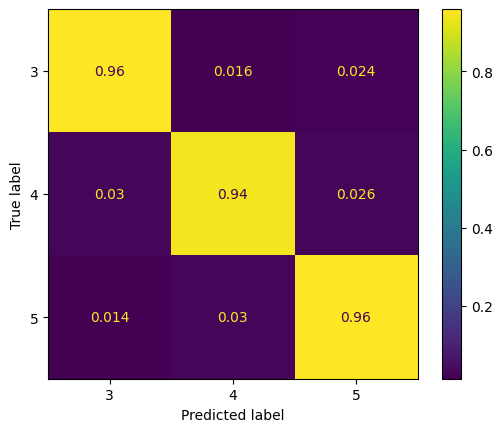

In [42]:
Y_pred_knn = mejor_modelo_knn.predict(X_test)

matriz_confusion_knn = confusion_matrix(Y_test, Y_pred_knn, labels=mejor_modelo_knn.classes_, normalize='true')
matriz_knn = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_knn, display_labels=mejor_modelo_knn.classes_)  
matriz_knn.plot()

In [43]:
print(classification_report(Y_test, Y_pred_knn))

              precision    recall  f1-score   support

           3       0.95      0.96      0.96       245
           4       0.95      0.94      0.95       266
           5       0.96      0.96      0.96       296

    accuracy                           0.95       807
   macro avg       0.95      0.95      0.95       807
weighted avg       0.95      0.95      0.95       807



El análisis detallado de los resultados obtenidos se presenta a continuación:

1. **Matriz de confusión:** La matriz de confusión muestra algunos errores en la clasificación. Aproximadamente un 3% de los textos de la clase 3 fueron incorrectamente clasificados como clase 4, y un 2.6% de los textos de la clase 4 fueron clasificados como clase 5.

2. **Sensibilidad:** Los valores de sensibilidad varían entre 0.94 y 0.96, lo que refleja una ligera disminución respecto al entrenamiento. Sin embargo, el modelo sigue siendo bastante preciso en la identificación de instancias dentro de cada clase.

3. **Precisión:** La precisión oscila entre 0.95 y 0.96, lo que indica que aunque el modelo sigue clasificando correctamente la mayoría de las instancias, comete algunos errores en el conjunto de prueba.

4. **F1-Score:** El F1-Score ponderado es de 0.95, lo que muestra que el modelo tiene un buen equilibrio entre precisión y sensibilidad, aunque su rendimiento ha disminuido en comparación con el conjunto de entrenamiento.

El modelo KNN presenta una buena capacidad de generalización, aunque no tan perfecta como en el conjunto de entrenamiento. El F1-Score de 0.95 en el conjunto de prueba muestra que, aunque el modelo es confiable, podría beneficiarse de ajustes adicionales en los hiperparámetros o el preprocesamiento de los datos para mejorar su precisión y sensibilidad.

## **6. Construcción del modelo 3: Árbol de decisión - Sara Benavides Mora**

De igual forma, se construye el tercer modelo haciendo uso del algoritmo Arból de Desición y de la técnica de validación cruzada con K-folds estratificados. 

### **6.1 Instanciación del modelo**

In [44]:
arbol_desicion = DecisionTreeClassifier(random_state=42)

### **6.2 Definición validación cruzada**

Se define el diccionario de hiperparámetros sobre los cuales se realizará la cross validation y se generan los k-folds estratificados para el mismo fin.

In [45]:
hiperparametros_dt = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'criterion': ['gini', 'entropy']
}

k_folds_dt = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
selector_dt = GridSearchCV(estimator = arbol_desicion, param_grid = hiperparametros_dt, cv=k_folds_rf, n_jobs=-1, verbose=2, scoring='f1_weighted')

### **6.3 Entrenamiento y selección del mejor modelo**

Posteriormente, se inicia el proceso de entrenamiento y selección del mejor modelo. Para el caso específico de este modelo, el mejor rendimiento, dado por la métrica weighted F1, se obtiene con los hiperparametros *criterion:* entropy, *max_depth:* 20, *min_samples_split:* 2

In [47]:
selector_dt.fit(X_train, Y_train)

print('Mejores hiperparámetros : ', selector_dt.best_params_)
print('Mejors puntaje F1: ', selector_dt.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Mejores hiperparámetros :  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}
Mejors puntaje F1:  0.9325811968482706


Una vez determinado el mejor modelo, se obtiene para su evaluación.

In [48]:
mejor_modelo_dt = selector_dt.best_estimator_

### **6.4 Evaluación del mejor modelo**

Se inicia evaluando el rendimiento del mejor modelo sobre el conjunto de datos de entrenamiento. 

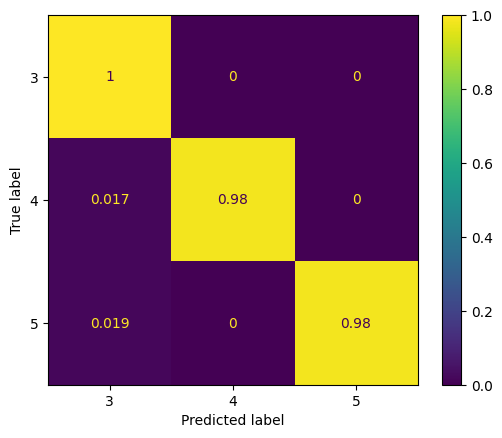

In [49]:
Y_pred_train_dt = mejor_modelo_dt.predict(X_train)

matriz_confusion_train_dt = confusion_matrix(Y_train, Y_pred_train_dt, labels=mejor_modelo_dt.classes_, normalize='true')
matriz_train_dt = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_train_dt, display_labels=mejor_modelo_dt.classes_)  
matriz_train_dt.plot()

In [50]:
print(classification_report(Y_train, Y_pred_train_dt))

              precision    recall  f1-score   support

           3       0.96      1.00      0.98       993
           4       1.00      0.98      0.99      1086
           5       1.00      0.98      0.99      1149

    accuracy                           0.99      3228
   macro avg       0.99      0.99      0.99      3228
weighted avg       0.99      0.99      0.99      3228



A continuación, se presenta un análisis detallado de los resultados:

1. **Matriz de confusión:** En la matriz de confusión del conjunto de entrenamiento, se observa que el modelo de árbol de decisión ha clasificado correctamente la mayoría de las instancias en sus clases correspondientes. Por ejemplo, la clase 3 fue correctamente clasificada en un 100% de los casos, y la clase 4 y 5 en un 98%. Sin embargo, existe una ligera confusión entre estas ultimas dos clases, lo cual es visible en los valores fuera de la diagonal principal. Estos errores, aunque son pequeños, indican que algunas opiniones que deberían estar en una clase específica fueron clasificados incorrectamente en otra clase similar.

2. **Sensibilidad:** La sensibilidad para la clase 3 es del 100%, lo que significa que todas las opiniones pertenecientes a esta clase fueron correctamente identificadas por el modelo. Para las clases 4 y 5, la sensibilidad es del 98%, lo que implica que el modelo identificó correctamente la gran mayoría de las opiniones de estas clases.

3. **Precisión:** La precisión del modelo es alta para todas las clases. Para las clases 4 y 5 es del 100% mostrando que todas las opiniones clasificadas en estas clases fueron asignadas correctamente, mientras que para la clase 3 hay una precisión del 96%, lo que significa que hubo un 4% de falsos positivos. 

4. **F1-Score:** El F1-score, que es una medida combinada de la precisión y la sensibilidad, es alto para todas las clases, con valor de 0.98 para la clase 3 y 0.99 para las clases 4 y 5. Estos resultados indican que el modelo tiene un rendimiento muy equilibrado en términos de precisión y sensibilidad, lo que sugiere que es capaz de manejar bien la clasificación de opiniones en estas clases.


Como conclusión preliminar, el modelo de árbol de decisión muestra un rendimiento muy bueno en el conjunto de entrenamiento, pues se obtuvieron métricas que sugieren una alta capacidad de clasificación y generalización. Así que, el modelo es confiable para poder clasificar las opiniones en relación con los ODS 3, 4 y 5.

Con el fin de evaluar la capacidad de generalización del modelo sobre instancias de datos nuevas, se repiten nuevamente las métricas sobre los datos predecidos por el modelo a partir del conjunto de datos de entrenamiento.

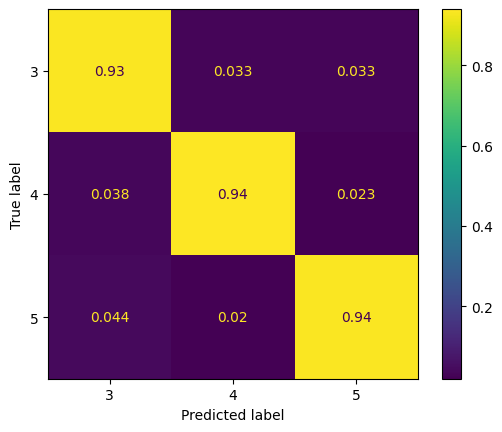

In [51]:
Y_pred_dt = mejor_modelo_dt.predict(X_test)

matriz_confusion_dt = confusion_matrix(Y_test, Y_pred_dt, labels=mejor_modelo_dt.classes_, normalize='true')
matriz_dt = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_dt, display_labels=mejor_modelo_dt.classes_)  
matriz_dt.plot()

In [52]:
print(classification_report(Y_test, Y_pred_dt))

              precision    recall  f1-score   support

           3       0.91      0.93      0.92       245
           4       0.95      0.94      0.94       266
           5       0.95      0.94      0.94       296

    accuracy                           0.94       807
   macro avg       0.94      0.94      0.94       807
weighted avg       0.94      0.94      0.94       807



El análisis detallado de los resultados obtenidos se presenta a continuación:

1. **Matriz de confusión:** Con los resultados obtenidos del conjunto de prueba, se observa que en la matriz de confusión el modelo mantiene un buen rendimiento, aunque con algunas diferencias respecto al conjunto de entrenamiento. La clase 3 fuer correctamente clasificada un 93% de los casos, y para las clases 4 y 5 un 94%. Para estas últimas dos clases la disminución del porcentaje de aciertos es mínima con un cambio de 4%, sin embargo, para la clase 3 hubo una disminución más notoria de un 7%. Al final, no son resultados negativos pues el modelo mantiene un buen porcentaje de aciertos para todas las clases y muestra su capacidad de generalización.

2. **Sensibilidad:** La sensibilidad para la clase 3 es del 93%, y para las clases 4 y 5 es del 94%, lo que sugiere que el modelo mantiene una buena capacidad para identificar correctamente estas clases.

3. **Precisión:** La precisión para las clases 4 y 5 es alta, ambas alcanzando un 95%, lo que significa que la mayoría de las opiniones fueron correctamente clasificadas. Ahora bien, para la clase 3 la precisión es del 91%, lo que indica que hay un pequeño porcentaje de falsos positivos, donde opiniones de otras clases fueron clasificadas erróneamente como clase 3.

4. **F1-Score:** El F1-score para las clases 4 y 5 es de 0.94, lo que indica un equilibrio sólido entre precisión y sensibilidad en la clasificación de estas clases. La clase 3, tiene un F1-score de 0.92, lo que refleja un rendimiento ligeramente inferior en comparación con las otras clases, debido principalmente a la reducción en precisión y sensibilidad.

El modelo de árbol de decisión muestra una buena capacidad de generalización en el conjunto de prueba, con una precisión, sensibilidad y F1-score altos para todas las clases. Sin embargo, se observa una ligera disminución en el rendimiento en comparación con el conjunto de entrenamiento, especialmente en la clase 3, que tiene una precisión menor. Esto sugiere que, aunque el modelo es fuerte, podría beneficiarse de ajustes adicionales para mejorar su capacidad de manejo de nuevas instancias de datos. Al final, el modelo es confiable, pero es importante considerar el potencial impacto de la ligera confusión entre clases en aplicaciones prácticas.

## **7. Determinación de palabras más importantes por clase**
***
Con el fin de brindarle infromación útil al negocio y entender los factores que hacen que un texto se clasifique en una clase específica, a continuación se presentan las palabras más importantes por cada clase.

In [15]:
def palabras_mas_importantes(dataFrame):
	vectorizador = TfidfVectorizer()
	vector = vectorizador.fit_transform(dataFrame['Textos_espanol'])
	vectorizador.get_feature_names_out()

	puntaje_vect = np.asarray(vector.mean(axis=0)).ravel().tolist()
	salida = pd.DataFrame({'Palabra': vectorizador.get_feature_names_out(), 'Peso': puntaje_vect})
	salida.sort_values(by='Peso',ascending=False,inplace=True)

	return salida.head(10)

for clase in range(3,6):
	print('Clase '+str(clase)+':')
	print()
	display(palabras_mas_importantes(datos_limpios[datos_limpios['sdg'] == str(clase)]))
	print('\n')
  

Clase 3:



,Palabra,Peso
8407,salud,0.046845
864,atencion,0.041811
8572,servicios,0.026050
6742,paises,0.021908
5972,mental,0.020335
6722,pacientes,0.018515
7355,primaria,0.017836
1270,calidad,0.017780
1020,años,0.017208
6534,ocde,0.017197




Clase 4:



,Palabra,Peso
3078,educacion,0.039059
3635,estudiantes,0.033365
3460,escuelas,0.028927
635,aprendizaje,0.022889
3676,evaluacion,0.021605
2980,docentes,0.020973
6278,ocde,0.020814
453,alumnos,0.019757
6474,paises,0.019463
3458,escuela,0.019371




Clase 5:



,Palabra,Peso
6915,mujeres,0.058128
4873,genero,0.043684
5137,hombres,0.025850
5247,igualdad,0.022812
7467,paises,0.020652
10193,trabajo,0.019768
2863,derechos,0.018166
10622,violencia,0.016844
7884,politicas,0.015443
8463,pueden,0.015043


Como se puede evidenciar, las palabras con más importancia o peso para cada clasificación corresponden con su significado o semántica. Por ejemplo, el ODS 3 trata temas relacionados a loa Salud y Bienestar y, al revisart las palabras con más peso, aquellas que reslatan son salud, atención, mentral, etc. Como se puede evidenciar, la gran mayoría de estas palabras tienen una relación directa con el ámbito de la salud y bienestar y, por ende, tiene sentido que tengan un gran peso en esta clasificación. De forma similar, para el ODS 5 el cual trata sobre Igualdad de Género, se pueden ver palabras que aportan gran importancia como mujeres, género, igualda, trabajo, derechos, violencia y pólitcas. 

Es necesario resaltar que, adémas de que estas palabras brindan información relevante para clasificar los textos, támbien son de alta relevancia para el negocio, ya que sirven como base para la toma de desiciones y acciones en la sociedad. Por ejemplo, para el ODS 5 se podria ahonadar en políticas de igualdad de género en el trabajo y de reducción de violencias basadas en género, ya que estas son las palabras que dominan en la vectorización. 

## **8. Predicción y almacenamiento de las predicciones**
***
Finalmente, se escoge el primer modelo (random forest) debido a su ligera dominancia en las metricas respecto a los otros modelos. Usando este modelo, se predicen las etiquetas de los datos presentes en el archivo *TestODScat_345.xlsx* y se almacenan usando una nueva columna llamada *Categoria* en un archivo bajo el nombre *TestODScat_345_predicted.xlsx*.

In [59]:
datos_validacion = pd.read_excel('./data/TestODScat_345.xlsx')

datos_validacion['sdg'] = mejor_modelo_rf.predict(vectorizador.transform(preprocesamiento(datos_validacion, False)['Textos_espanol']))

datos_validacion.to_excel('./data/TestODScat_345_predicted.xlsx')